Because of lots of issues with output files, let's just write a script to hack it together.

In [ ]:
def parse_file(filename):
    IS_PRETRAIN = False

    f = open(filename, "r")
    txt = f.read()

    if "pretrainModel" in txt:
        IS_PRETRAIN = True
        _, txt = txt.split("pretrainModel Started ... ")
        pretrain, txt = txt.split("trainModel Started ... ")
        train, test = txt.split("testing started")

        pretrain = pretrain.split("\n")[1:][:-4]
    else:
        _, txt = txt.split("trainModel Started ... ")
        train, test = txt.split("testing started")

    train = train.split("\n")[6:-2]
    _, test_u, test_a = test.split("****************************************")
    test_u = test_u.split("\n")[1:15]
    test_a = test_a.split("\n")[1:15]

    pretrain_data = {}

    if IS_PRETRAIN:
        for line in pretrain:
            epoch, remainder = line.split("time used: ")
            epoch = epoch.split("epoch ")[1]
            time, remainder = remainder.split("seconds  train loss: ")
            t_loss, v_loss = remainder.split(" validation loss: ")

            epoch, time, t_loss, v_loss = int(epoch.strip()), int(time.strip()), float(t_loss.strip()), float(v_loss.strip())
            pretrain_data[epoch] = (time, t_loss, v_loss)

    train_data = {}

    for line in train[:100]:
        epoch, remainder = line.split("time used: ")
        epoch = epoch.split("epoch ")[1]
        time, remainder = remainder.split("seconds  train loss: ")
        t_loss, remainder = remainder.split(" validation unseen nodes loss: ")
        vu_loss, va_loss = remainder.split(" validation all nodes loss: ")

        epoch, time, t_loss, vu_loss, va_loss = int(epoch.strip()), int(time.strip()), float(t_loss.strip()), float(vu_loss.strip()), float(va_loss.strip())
        train_data[epoch] = (time, t_loss, vu_loss, va_loss)

    test_u_summary, test_a_summary = {}, {}

    test_u_summary['torch_mse'] = float(test_u[0].split(", ")[-1])
    test_a_summary['torch_mse'] = float(test_a[0].split(", ")[-1])

    test_u_data, test_a_data = {}, {}

    for line in test_u[1:]:
        step, _, _, _, _, _, _, mse, rmse, mae, mape = line.split(", ")
        if step == "all pred steps":
            test_u_data[0] = (float(mse), float(rmse), float(mae), float(mape))
        else:
            test_u_data[int(step.split(" step")[0])] = (float(mse), float(rmse), float(mae), float(mape))

    for line in test_a[1:]:
        step, _, _, _, _, _, _, mse, rmse, mae, mape = line.split(", ")
        if step == "all pred steps":
            test_a_data[0] = (float(mse), float(rmse), float(mae), float(mape))
        else:
            test_a_data[int(step.split(" step")[0])] = (float(mse), float(rmse), float(mae), float(mape))

    f.close()
    return pretrain_data, train_data, test_u_data, test_a_data, test_u_summary, test_a_summary

Then upload your logs zip file

In [ ]:
!unzip logs-metr.zip -d logs-metr
!unzip logs-pems.zip -d logs-pems

unzip:  cannot find or open logs-metr.zip, logs-metr.zip.zip or logs-metr.zip.ZIP.
unzip:  cannot find or open logs-pems.zip, logs-pems.zip.zip or logs-pems.zip.ZIP.


In [ ]:
%cd /content/logs-pems

/content/logs-pems


In [ ]:
import os
from pprint import pprint

files = [f for f in os.listdir('.') if os.path.isfile(f)]
print(len(files))
variants = sorted(set(list(map(lambda x: x.split(",")[0], files))))
variants.remove('scpt')
print(variants)

variant_data = {}

for variant in variants:
    variant_arr = []
    for seed in range(1, 11, 1):
        pretrain, train, val_u, val_a, test_u_summary, test_a_summary = parse_file(f"{variant},{seed}")
        variant_arr.append({
            "pretrain": pretrain,
            "train": train,
            "val_u": val_u,
            "val_a": val_a,
            "test_u_summary": test_u_summary,
            "test_a_summary": test_a_summary,
        })

    variant_data[variant] = variant_arr

130
['features-1', 'features-3', 'features-4', 'features-5', 'gwn', 'larger-radius', 'larger-subgraph', 'less-hidden', 'lr-0001', 'lr-0003', 'lr-0010', 'no-graph-norm']


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patheffects as PathEffects

Graphs that I want to generate:
- Pre-training, validation loss (alpha 0.5)
- Pre-training, train loss (alpha 0.5)
- Pre-training, validation averages
- Pre-training, train averages
- Training, train/validation all/validation unseen (alpha 0.5)
- Training, train/validation all/validation unseen (averages)
- 12 step prediction, unseen nodes, averages
- 12 step prediction, all nodes, averages

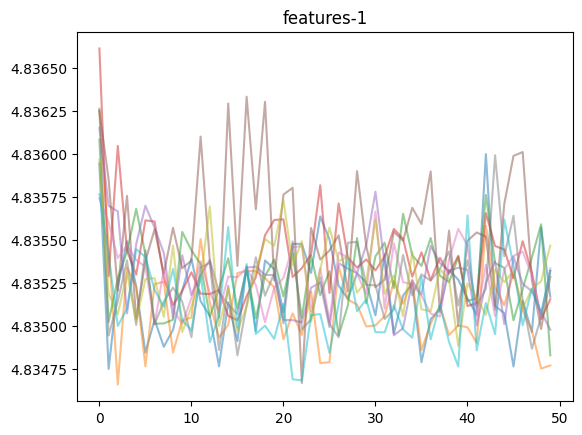

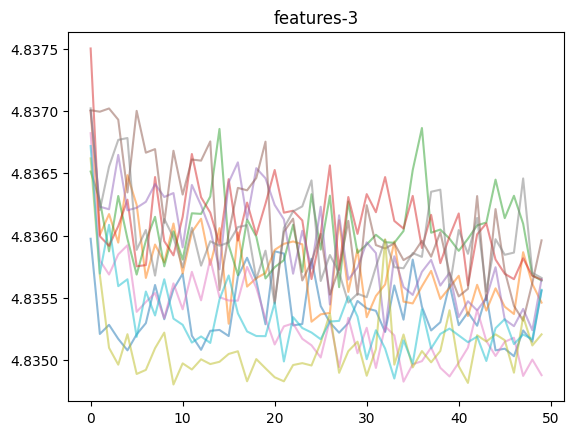

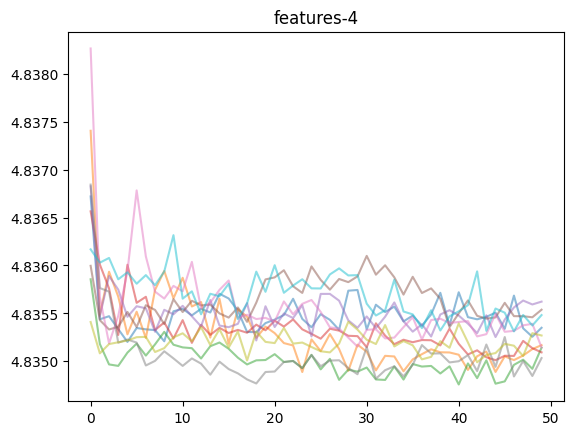

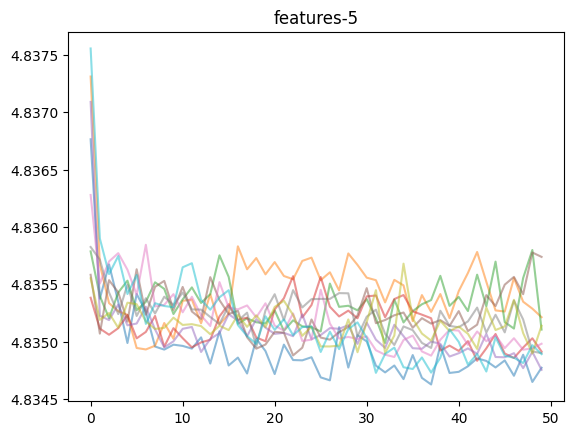

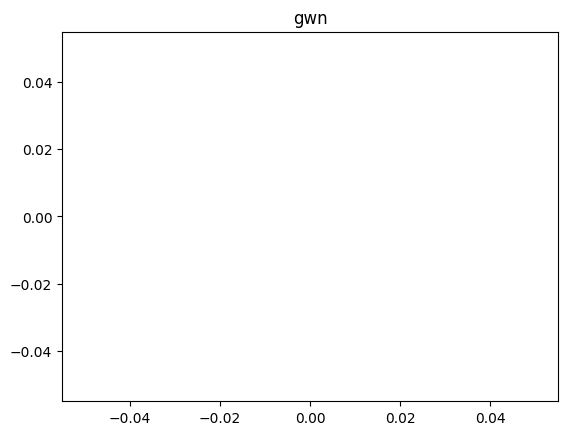

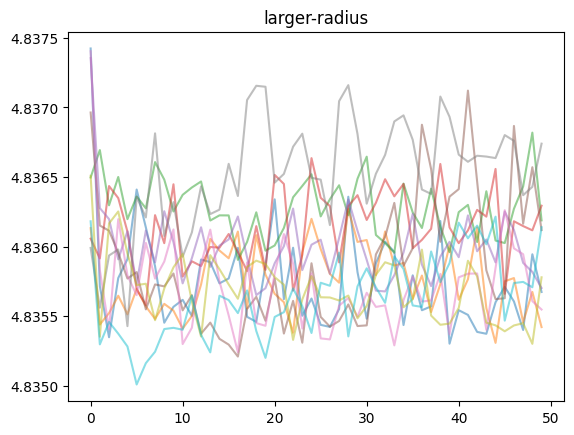

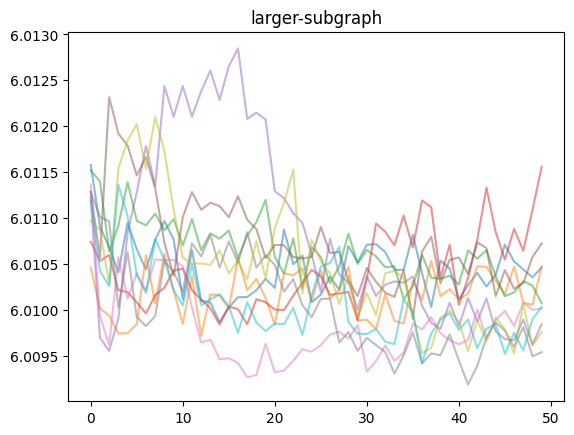

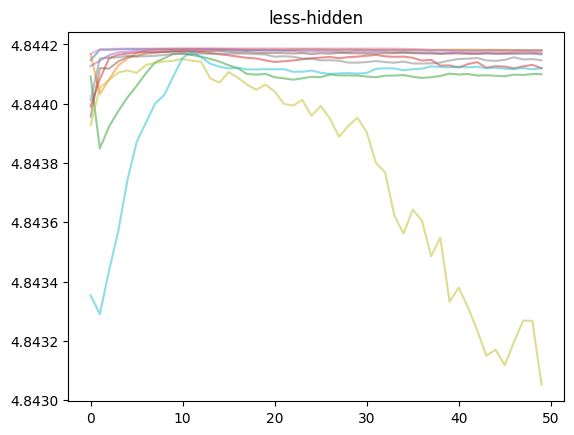

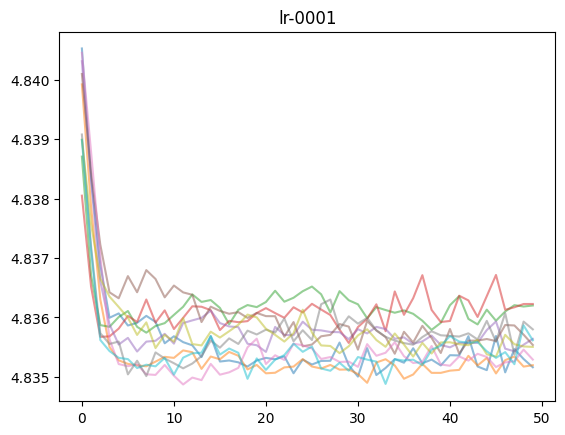

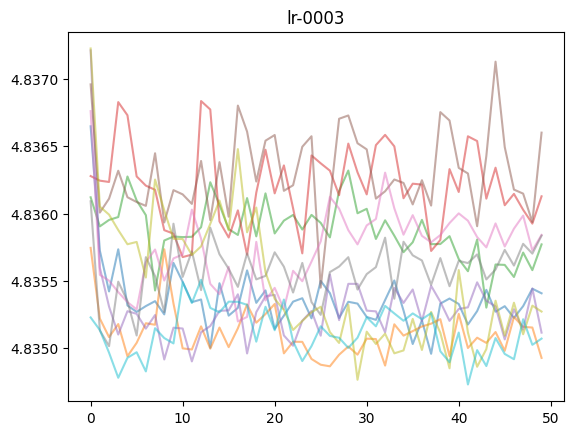

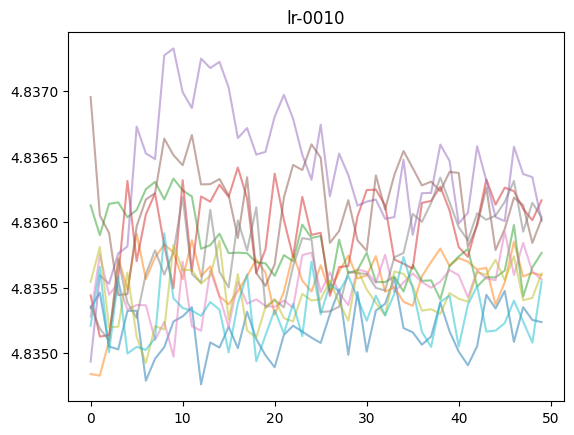

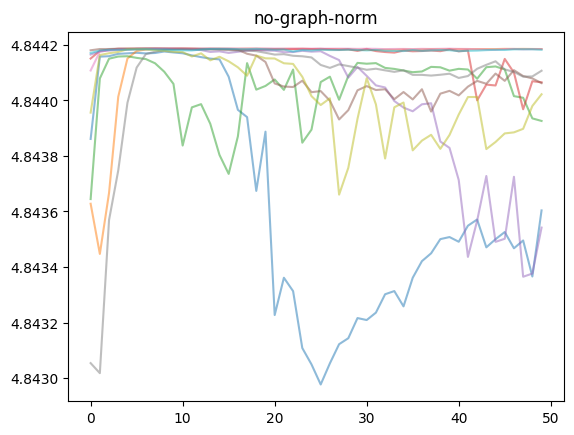

In [ ]:
# # pretrain graph
for k, v in variant_data.items():
    try:
        for i in v:
            xpoints = np.array(list(i['pretrain'].keys()))
            t_loss = np.array(list(map(lambda x: x[1], i['pretrain'].values())))
            v_loss = np.array(list(map(lambda x: x[2], i['pretrain'].values())))

            # plt.plot(xpoints, t_loss)
            plt.plot(xpoints, v_loss, alpha=0.5)
        plt.title(k)
        plt.show()

    except KeyError:
        continue

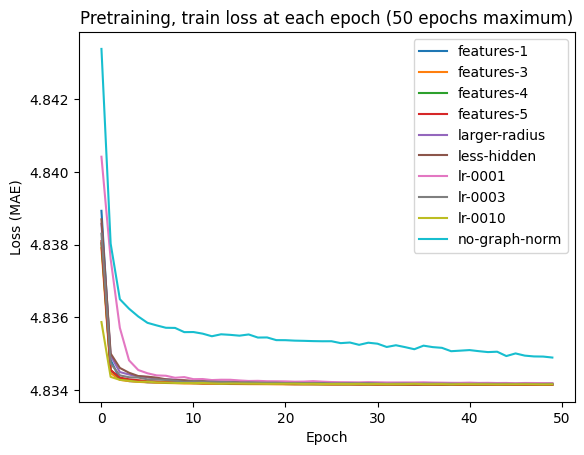

In [ ]:
# # pretrain graph
legends = []
for k, v in variant_data.items():
    if k not in ['gwn', 'larger-subgraph', 'larger-subgraph-old']:
        legends.append(k)
        try:
            t_loss = np.zeros(50)
            v_loss = np.zeros(50)
            for i in v:
                xpoints = np.array(list(i['pretrain'].keys()))[:50]
                t_loss += np.array(list(map(lambda x: x[1], i['pretrain'].values())))[:50]
                v_loss += np.array(list(map(lambda x: x[2], i['pretrain'].values())))[:50]

            t_loss /= len(v)
            v_loss /= len(v)
            plt.plot(xpoints, t_loss)
        except KeyError:
            continue

plt.title("Pretraining, train loss at each epoch (50 epochs maximum)")
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.legend(legends)
plt.show()

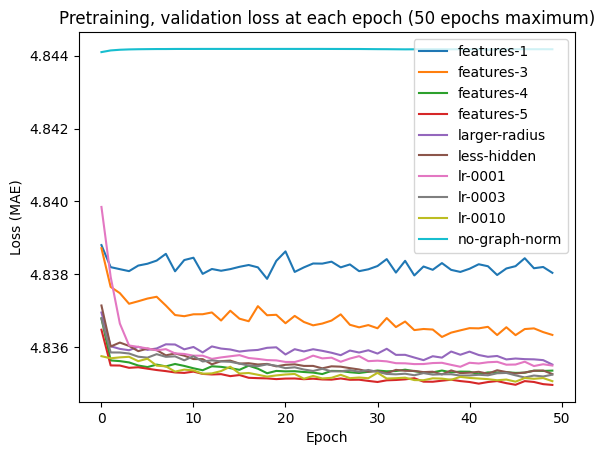

In [ ]:
# # pretrain graph
legends = []
for k, v in variant_data.items():
    if k not in ['gwn', 'larger-subgraph', 'larger-subgraph-old']:
        legends.append(k)
        try:
            t_loss = np.zeros(50)
            v_loss = np.zeros(50)
            for i in v:
                xpoints = np.array(list(i['pretrain'].keys()))[:50]
                t_loss += np.array(list(map(lambda x: x[1], i['pretrain'].values())))[:50]
                v_loss += np.array(list(map(lambda x: x[2], i['pretrain'].values())))[:50]

            t_loss /= len(v)
            v_loss /= len(v)
            plt.plot(xpoints, v_loss)
        except KeyError:
            continue

plt.title("Pretraining, validation loss at each epoch (50 epochs maximum)")
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.legend(legends)
plt.show()

features-1 & 0.13324
features-3 & 0.13313
features-4 & 0.13329
features-5 & 0.13317
gwn & 0.14753
larger-radius & 0.1334
larger-subgraph & 0.13332
less-hidden & 0.13332
lr-0001 & 0.13338
lr-0003 & 0.13339
lr-0010 & 0.13345
no-graph-norm & 0.13909


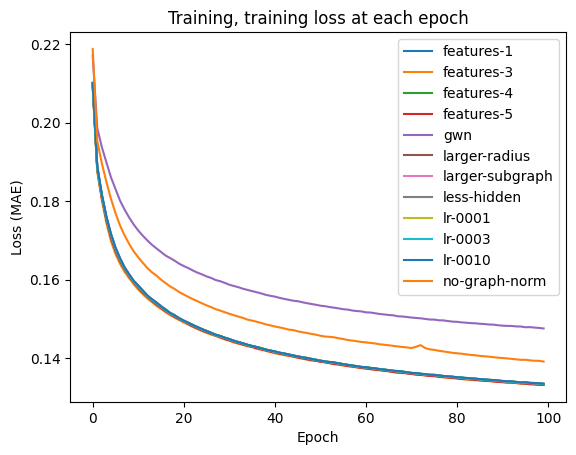

In [ ]:
# pretrain graph
legends = []
for k, v in variant_data.items():
    legends.append(k)
    try:
        t_loss = np.zeros(100)
        for i in v:
            xpoints = np.array(list(i['train'].keys()))
            t_loss += np.array(list(map(lambda x: x[1], i['train'].values())))

        t_loss /= len(v)
        plt.plot(xpoints, t_loss)

        print(k, round(t_loss[-1], 5), sep=" & ")
    except KeyError:
        continue

plt.title('Training, training loss at each epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.legend(legends)
plt.show()

features-1 & 0.23503
features-3 & 0.23412
features-4 & 0.23299
features-5 & 0.23228
gwn & 0.2445
larger-radius & 0.22899
larger-subgraph & 0.22878
less-hidden & 0.23925
lr-0001 & 0.22866
lr-0003 & 0.22898
lr-0010 & 0.22933
no-graph-norm & 0.23566


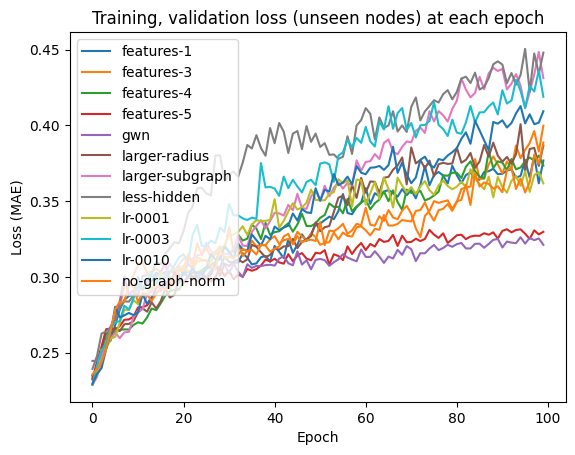

In [ ]:
# pretrain graph
legends = []
for k, v in variant_data.items():
    legends.append(k)
    try:
        t_loss = np.zeros(100)
        for i in v:
            xpoints = np.array(list(i['train'].keys()))
            t_loss += np.array(list(map(lambda x: x[2], i['train'].values())))

        t_loss /= len(v)
        plt.plot(xpoints, t_loss)

        print(k, round(min(t_loss), 5), sep=" & ")
    except KeyError:
        continue

plt.title('Training, validation loss (unseen nodes) at each epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.legend(legends)
plt.show()

features-1 & 0.21588
features-3 & 0.21542
features-4 & 0.21453
features-5 & 0.21275
gwn & 0.22118
larger-radius & 0.21372
larger-subgraph & 0.21479
less-hidden & 0.21146
lr-0001 & 0.21572
lr-0003 & 0.21469
lr-0010 & 0.21524
no-graph-norm & 0.2149


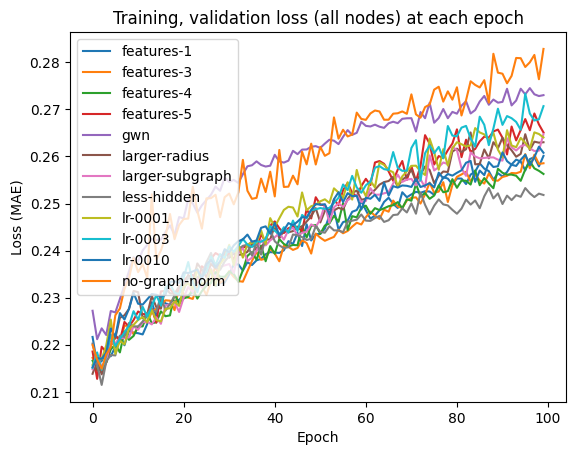

In [ ]:
# pretrain graph
legends = []
for k, v in variant_data.items():
    legends.append(k)
    try:
        t_loss = np.zeros(100)
        for i in v:
            xpoints = np.array(list(i['train'].keys()))
            t_loss += np.array(list(map(lambda x: x[3], i['train'].values())))

        t_loss /= len(v)

        print(k, round(min(t_loss), 5), sep=" & ")
        plt.plot(xpoints, t_loss)
    except KeyError:
        continue

plt.title('Training, validation loss (all nodes) at each epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.legend(legends)
plt.show()

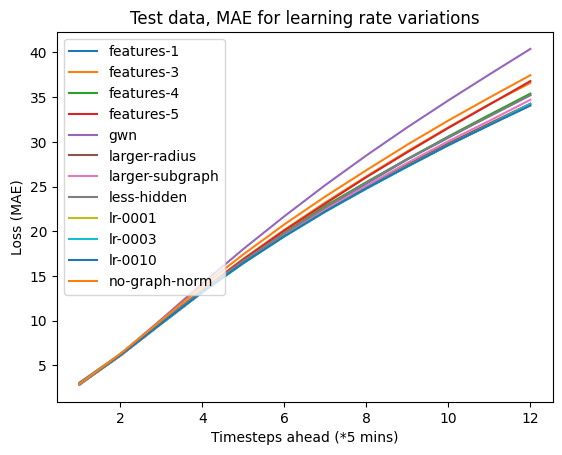

In [ ]:
# pretrain graph
legends = []
for k, v in variant_data.items():
    legends.append(k)
    try:
        mse = np.zeros(12)
        for i in v:
            xpoints = np.array(list(i['val_u'].keys()))[1:]
            mse += np.array(list(map(lambda x: x[0], i['val_u'].values()))[1:])

        mse /= len(v)
        plt.plot(xpoints, mse)
    except KeyError:
        continue

plt.title('Test data, MAE for learning rate variations')
plt.xlabel('Timesteps ahead (*5 mins)')
plt.ylabel('Loss (MAE)')
plt.legend(legends)
plt.show()

best performance for 0 steps is lr-0001 with 4.446283817289999
best performance for 1 steps is gwn with 1.6757272601000004
best performance for 2 steps is lr-0001 with 2.4706101656
best performance for 3 steps is lr-0001 with 3.10680191517
best performance for 4 steps is lr-0001 with 3.62793114185
best performance for 5 steps is lr-0001 with 4.04766352175
best performance for 6 steps is lr-0003 with 4.40366954803
best performance for 7 steps is lr-0003 with 4.7073210239400005
best performance for 8 steps is lr-0003 with 4.9706491470300005
best performance for 9 steps is lr-0003 with 5.21179108619
best performance for 10 steps is lr-0001 with 5.43687610624
best performance for 11 steps is lr-0010 with 5.63793888092
best performance for 12 steps is lr-0010 with 5.82765226365
['all', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


Text(0, 0.5, 'Number of prediction steps')

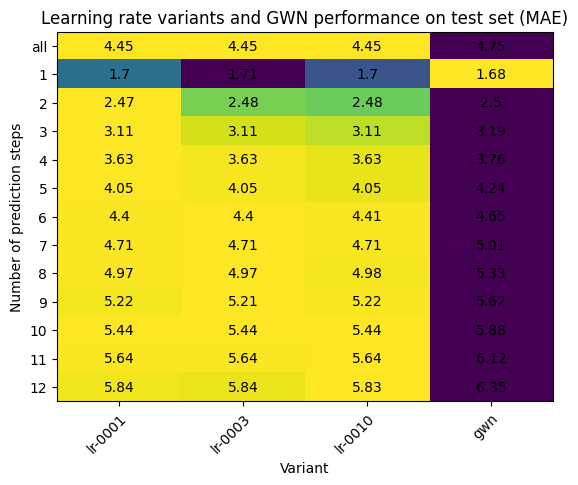

In [ ]:
variants = ['lr-0001', 'lr-0003', 'lr-0010', 'gwn']
heatmap = np.zeros((13, len(variants)))
minimums = np.zeros((13, len(variants)))

for i in range(13):
    minimum = float('inf')
    min_key = None
    for idx, k in enumerate(variants):
        try:
            val = sum(a['val_u'][i][1] for a in variant_data[k])/10
            heatmap[i][idx] = val
            minimums[i][idx] = val
            # print(val, k)
            # print(val, minimum, k)
            if val < minimum:
                min_key = k
                minimum = val
            # print("minimum is", minimum, min_key)

        except KeyError:
            continue

    heatmap[i] = (heatmap[i] - np.min(heatmap[i]))/(np.max(heatmap[i]) - np.min(heatmap[i]))

    print("best performance for", i, "steps is", min_key, "with", minimum)

fig, ax = plt.subplots()
im = ax.imshow(heatmap, cmap="viridis_r")

yticks = ['all'] + list(range(1, 13))
print(yticks)

for i in range(len(minimums)):
    for j in range(len(minimums[0])):
        text = ax.text(j, i, round(minimums[i, j], 2),
                       ha="center", va="center", color="k")

ax.set_xticks(np.arange(len(variants)), labels=variants)
ax.set_yticks(np.arange(13), labels=yticks)
ax.set_aspect('auto')

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.title("Learning rate variants and GWN performance on test set (MAE)")
plt.xlabel("Variant")
plt.ylabel("Number of prediction steps")


best performance for 0 steps is lr-0001 with 4.446283817289999
best performance for 1 steps is gwn with 1.6757272601000004
best performance for 2 steps is larger-subgraph with 2.46184673309
best performance for 3 steps is larger-subgraph with 3.10373187064
best performance for 4 steps is lr-0001 with 3.62793114185
best performance for 5 steps is lr-0001 with 4.04766352175
best performance for 6 steps is lr-0003 with 4.40366954803
best performance for 7 steps is lr-0003 with 4.7073210239400005
best performance for 8 steps is lr-0003 with 4.9706491470300005
best performance for 9 steps is lr-0003 with 5.21179108619
best performance for 10 steps is lr-0001 with 5.43687610624
best performance for 11 steps is lr-0010 with 5.63793888092
best performance for 12 steps is lr-0010 with 5.82765226365
['all', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


Text(0.5, 1.0, 'Normalised heatmap of test (unseen) MAE')

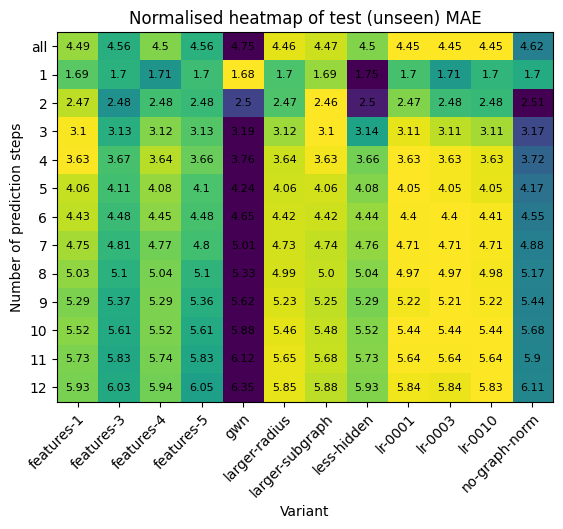

In [ ]:
heatmap = np.zeros((13, len(variant_data.keys())))
variants = sorted(list(variant_data.keys()))
minimums = np.zeros((13, len(variants)))

for i in range(13):
    minimum = float('inf')
    min_key = None
    for idx, k in enumerate(variants):
        try:
            val = sum(a['val_u'][i][1] for a in variant_data[k])/10
            heatmap[i][idx] = val
            minimums[i][idx] = val
            # print(val, k)
            # print(val, minimum, k)
            if val < minimum:
                min_key = k
                minimum = val
            # print("minimum is", minimum, min_key)

        except KeyError:
            continue

    heatmap[i] = (heatmap[i] - np.min(heatmap[i]))/(np.max(heatmap[i]) - np.min(heatmap[i]))

    print("best performance for", i, "steps is", min_key, "with", minimum)

fig, ax = plt.subplots()
im = ax.imshow(heatmap, cmap="viridis_r")

yticks = ['all'] + list(range(1, 13))
print(yticks)

for i in range(len(minimums)):
    for j in range(len(minimums[0])):
        text = ax.text(j, i, round(minimums[i, j], 2),
                       ha="center", va="center", color="k", size=8)

ax.set_xticks(np.arange(len(variants)), labels=variants)
ax.set_yticks(np.arange(13), labels=yticks)
ax.set_aspect('auto')


plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.xlabel("Variant")
plt.ylabel("Number of prediction steps")
plt.title("Normalised heatmap of test (unseen) MAE")

best performance for 0 steps is lr-0003 with 4.432508802419999
best performance for 1 steps is gwn with 1.6745750427199997
best performance for 2 steps is lr-0003 with 2.43118731975
best performance for 3 steps is lr-0003 with 3.04322724342
best performance for 4 steps is lr-0003 with 3.54920105936
best performance for 5 steps is lr-0003 with 3.9744051694799998
best performance for 6 steps is lr-0003 with 4.33836202622
best performance for 7 steps is lr-0003 with 4.66108584404
best performance for 8 steps is lr-0003 with 4.951916742329999
best performance for 9 steps is lr-0003 with 5.2200671673
best performance for 10 steps is lr-0003 with 5.47061910629
best performance for 11 steps is lr-0003 with 5.688290166850001
best performance for 12 steps is lr-0003 with 5.89175486563
['all', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


Text(0.5, 1.0, 'Normalised heatmap of test (all) MAE')

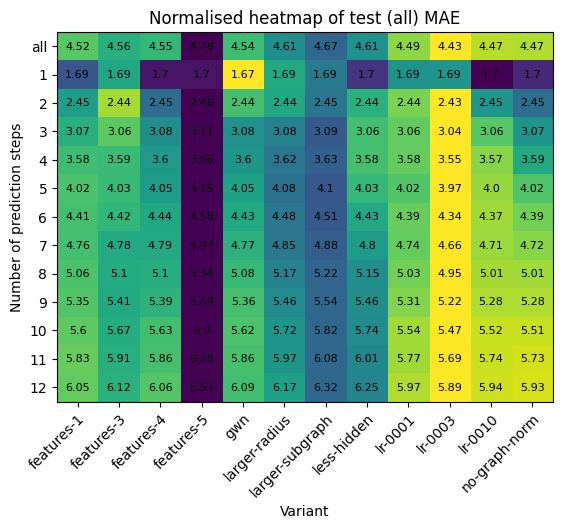

In [ ]:
heatmap = np.zeros((13, len(variant_data.keys())))
variants = sorted(list(variant_data.keys()))
minimums = np.zeros((13, len(variants)))

for i in range(13):
    minimum = float('inf')
    min_key = None
    for idx, k in enumerate(variants):
        try:
            val = sum(a['val_a'][i][1] for a in variant_data[k])/10
            heatmap[i][idx] = val
            minimums[i][idx] = val
            # print(val, k)
            # print(val, minimum, k)
            if val < minimum:
                min_key = k
                minimum = val
            # print("minimum is", minimum, min_key)

        except KeyError:
            continue

    heatmap[i] = (heatmap[i] - np.min(heatmap[i]))/(np.max(heatmap[i]) - np.min(heatmap[i]))

    print("best performance for", i, "steps is", min_key, "with", minimum)

fig, ax = plt.subplots()
im = ax.imshow(heatmap, cmap="viridis_r")

yticks = ['all'] + list(range(1, 13))
print(yticks)

for i in range(len(minimums)):
    for j in range(len(minimums[0])):
        text = ax.text(j, i, round(minimums[i, j], 2),
                       ha="center", va="center", color="k", size=8)

ax.set_xticks(np.arange(len(variants)), labels=variants)
ax.set_yticks(np.arange(13), labels=yticks)
ax.set_aspect('auto')

ax.set_xticks(np.arange(len(variants)), labels=variants)
ax.set_yticks(np.arange(13), labels=yticks)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.xlabel("Variant")
plt.ylabel("Number of prediction steps")
plt.title("Normalised heatmap of test (all) MAE")